## Statistical Analysis of Tickets per Bus Stop & Poverty Rates

In [203]:
# imports
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely import wkt, geometry
from shapely.geometry import Point

In [135]:
# reading in CSVs
df1 = pd.read_csv('/Users/Marcy_Student/Desktop/Passion-Projects/Datathon-September-2025/data/poverty/non-exempt2.csv')
df2 = pd.read_csv('/Users/Marcy_Student/Desktop/Passion-Projects/Datathon-September-2025/data/poverty/nyc-poverty-population.csv')
df3 = pd.read_csv('/Users/Marcy_Student/Desktop/Passion-Projects/Datathon-September-2025/data/poverty/modified-zip.csv')

## Normalizing Data (For Statistical Testing)

### Mapping Bus Stop Coordinates to ZIP codes (via modified zip code dataset)

What we have here in our df3 is our modified zip code dataset from the 5 boroughs of NYC. In this dataset, we are given multipolygon coordinates of the ZIP codes, which are essentially shapes that encover an entire ZIP code area. Using our bus stop coordinates, which are single point coordinates, we can calculate where these points fit into the multipolygon area, and thus assign them the ZIP code they fall into.

<br>

In [136]:
# coordinate variables
bus_stop_coords = df1[['stop_name', 'bus_stop_latitude', 'bus_stop_longitude']]
zip_coords = df3[['MODZCTA', 'the_geom']]

# Converting object multipolygon coordinates from WKT
zip_coords['the_geom'] = zip_coords['the_geom'].apply(wkt.loads)

# geoDF for ZIPs
gdf_zip = gpd.GeoDataFrame(zip_coords, geometry='the_geom', crs='EPSG:4326')

# geoDF for bus_stop
gdf_bus = gpd.GeoDataFrame(bus_stop_coords, geometry=gpd.points_from_xy(df1['bus_stop_longitude'], df1['bus_stop_latitude']), crs='EPSG:4326')

# joining the zip codes
gdf_joined = gpd.sjoin(gdf_bus, gdf_zip, how='left', predicate='within')
gdf_joined

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_38269/1882686157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_coords['the_geom'] = zip_coords['the_geom'].apply(wkt.loads)


,stop_name,bus_stop_latitude,bus_stop_longitude,geometry,index_right,MODZCTA
0,HILLSIDE AV/268 ST,40.738862,-73.701373,POINT (-73.70137 40.73886),70.0,11004.0
1,HILLSIDE AV/267 ST,40.738702,-73.701458,POINT (-73.70146 40.7387),70.0,11004.0
2,HILLSIDE AV/268 ST,40.738768,-73.701868,POINT (-73.70187 40.73877),70.0,11004.0
3,HILLSIDE AV/267 ST,40.738650,-73.701998,POINT (-73.702 40.73865),170.0,11429.0
4,HILLSIDE AV/266 ST,40.738531,-73.703238,POINT (-73.70324 40.73853),70.0,11004.0
...,...,...,...,...,...,...
2884,SOUTH AV/TELEPORT DR,40.607664,-74.179454,POINT (-74.17945 40.60766),59.0,10314.0
2885,SOUTH AV/TRAVIS AV,40.602480,-74.184125,POINT (-74.18412 40.60248),59.0,10314.0
2886,SOUTH AV/TRAVIS AV,40.602410,-74.184560,POINT (-74.18456 40.60241),59.0,10314.0
2887,SOUTH AV/WEST SHORE PLAZA,40.601885,-74.191752,POINT (-74.19175 40.60188),59.0,10314.0


In [137]:
# Now that we've mapped bus stops coords to ZIPs, we can remove geoDF
new_df = gdf_joined.drop(columns=['geometry', 'index_right', 'bus_stop_latitude', 'bus_stop_longitude'])
new_df

# and now merge to our non-exempt aggregated dataset
df_merged = pd.merge(new_df, df1, how='left', on='stop_name')
df_merged

,stop_name,MODZCTA,Unnamed: 0,Borough,bus_stop_georeference,bus_stop_latitude,bus_stop_longitude,ticket_count
0,HILLSIDE AV/268 ST,11004.0,0,QUEENS,POINT (-73.701373 40.738862),40.738862,-73.701373,15
1,HILLSIDE AV/268 ST,11004.0,2,QUEENS,POINT (-73.701868 40.738768),40.738768,-73.701868,7
2,HILLSIDE AV/267 ST,11004.0,1,QUEENS,POINT (-73.701458 40.738702),40.738702,-73.701458,39
3,HILLSIDE AV/267 ST,11004.0,3,QUEENS,POINT (-73.701998 40.73865),40.738650,-73.701998,58
4,HILLSIDE AV/268 ST,11004.0,0,QUEENS,POINT (-73.701373 40.738862),40.738862,-73.701373,15
...,...,...,...,...,...,...,...,...
4938,SOUTH AV/TRAVIS AV,10314.0,2886,STATEN_ISLAND,POINT (-74.18456 40.60241),40.602410,-74.184560,1
4939,SOUTH AV/WEST SHORE PLAZA,10314.0,2887,STATEN_ISLAND,POINT (-74.191752 40.601885),40.601885,-74.191752,1
4940,SOUTH AV/WEST SHORE PLAZA,10314.0,2888,STATEN_ISLAND,POINT (-74.192639 40.601619),40.601619,-74.192639,4
4941,SOUTH AV/WEST SHORE PLAZA,10314.0,2887,STATEN_ISLAND,POINT (-74.191752 40.601885),40.601885,-74.191752,1


In [ ]:
# adding same column name and dropping old column name of ZIP codes
df2['MODZCTA'] = df2[['placeName']]
df2 = df2.drop(columns='placeName')

***
##### Quick pivot to answer a sub-question we asked:
- How do the count of violations differ across the boroughs?

In [237]:
# checking ticket distribution across the boroughs
df_merged.groupby('Borough')['ticket_count'].sum()

Borough
BRONX            1818310
BROOKLYN         1047934
MANHATTAN        1223122
QUEENS            752135
STATEN_ISLAND      43301
Name: ticket_count, dtype: int64

***

In [179]:
# feature engineering poverty rates
df2['poverty_rate'] = (df2['Value:Count_Person_BelowPovertyLevelInThePast12Months']/df2['Value:Count_Person'])*100

# checking highest/lowest percentage
max = df2[df2['poverty_rate']==df2['poverty_rate'].max()]
min = df2[df2['poverty_rate']==df2['poverty_rate'].min()]

### Quick Internal Investigation using a Quick Visualization:

In [171]:
# imports to visualize (for initial review)
import seaborn as sns
import matplotlib.pyplot as plt

In [172]:
# merge poverty and ticket data by ZIP
merged2_df = pd.merge(df_merged, df2, how='inner', on='MODZCTA')
merged2_df

# grouped ticket count and poverty by MODZCTA, respectively, to get their means
grouped_merge = merged2_df.groupby('MODZCTA')['ticket_count'].mean()
grouped_merge2 = merged2_df.groupby('MODZCTA')['poverty_rate'].mean()
grouped_merge2

# merged again
merge3 = pd.merge(grouped_merge2, grouped_merge, how='inner', on='MODZCTA', left_index=False)
merge3

,poverty_rate,ticket_count
MODZCTA,,
10001.0,13.368168,205.776119
10002.0,26.326715,377.333333
10003.0,8.875470,1164.866667
10004.0,2.840092,1197.400000
10005.0,6.054949,1823.000000
...,...,...
11433.0,13.749586,1222.836066
11434.0,10.565152,334.685714
11435.0,13.778998,1699.176471


Text(0, 0.5, 'Tickets Issued')

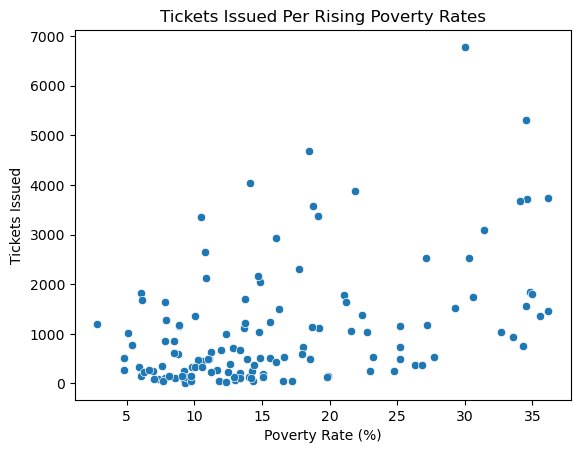

In [173]:
# plotting to get an idea of the distribution
sns.scatterplot(merge3, x='poverty_rate', y='ticket_count')
plt.title('Tickets Issued Per Rising Poverty Rates')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Tickets Issued')

In [235]:
merge3[merge3['ticket_count']==merge3['ticket_count'].max()]

,poverty_rate,ticket_count,poverty_level
MODZCTA,,,
10458.0,30.049002,6780.8,High


#### After viewing the chart, it appears at first glance that the tickets issued seem to bunch up around 5-20% poverty levels.

***

<br>

## ANOVA Test

Let's establish some hypotheses and significance level:

- Null Hypothesis: There is no statistically significant change of violation averages per poverty bin
- Alternative Hypothesis: There is a statistically significant change of violation averages per poverty bin

- Significance Level: 0.05
    - We will use this level, as it seems appropiate to allow only a 5% chance of a Type I Error.

#### Let's now create bins for poverty rates so we can run ANOVA test
#####  We will separate into high, medium, and low poverty rates by using percentiles:

In [205]:
# Creating bins for ANOVA test

# creating quantiles for bins
df_sorted = merge3.sort_values(by='poverty_rate', ascending=False)
high = df_sorted['poverty_rate'].quantile(0.75)
low = df_sorted['poverty_rate'].quantile(0.25)
low

np.float64(9.764105386977457)

In [212]:
# assigning quantiles to poverty rates to create bins of high, medium, or low poverty rates
poverty_level = []
for i in merge3['poverty_rate']:
    if i >= high:
        poverty_level.append('High')
    elif i <= low:
        poverty_level.append('Low')
    else:
        poverty_level.append('Medium')

# adding back into our merge3
merge3['poverty_level'] = poverty_level
merge3

,poverty_rate,ticket_count,poverty_level
MODZCTA,,,
10001.0,13.368168,205.776119,Medium
10002.0,26.326715,377.333333,High
10003.0,8.875470,1164.866667,Low
10004.0,2.840092,1197.400000,Low
10005.0,6.054949,1823.000000,Low
...,...,...,...
11433.0,13.749586,1222.836066,Medium
11434.0,10.565152,334.685714,Medium
11435.0,13.778998,1699.176471,Medium


In [225]:
# splitting our bins into 3 variables
low_bin = merge3.loc[merge3['poverty_level']=='Low']
medium_bin = merge3.loc[merge3['poverty_level']=='Medium']
high_bin = merge3.loc[merge3['poverty_level']=='High']

##### Finally, our ANOVA Test!!!

In [226]:
# imports
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [228]:
#conduct ANOVA test
f_stat1, p_stat1 = f_oneway(
                    low_bin['ticket_count'],
                    medium_bin['ticket_count'],
                    high_bin['ticket_count']
)
print(f'F-Statistic: {f_stat1}, P-Value: {p_stat1}')

F-Statistic: 11.337806346603369, P-Value: 2.9474398362879494e-05


<br>

### Given our statistics, let's do a Post-Hoc Test :

In [229]:
# Tukey's Test

tukey_result = pairwise_tukeyhsd(endog=merge3['ticket_count'],
                                 groups=merge3['poverty_level'],
                                 alpha=0.05)
print(tukey_result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
  High    Low -1270.1859    0.0 -1925.0631 -615.3088   True
  High Medium  -877.5515 0.0011 -1447.6379  -307.465   True
   Low Medium   392.6345 0.2354   -177.452  962.7209  False
-----------------------------------------------------------


In [233]:
low_bin.describe(), medium_bin.describe(), high_bin.describe()

(       poverty_rate  ticket_count
 count     33.000000     33.000000
 mean       7.412185    557.130138
 std        1.656817    535.731423
 min        2.840092     10.500000
 25%        6.174750    142.222222
 50%        7.806526    278.500000
 75%        8.832552    859.873950
 max        9.759260   1823.000000,
        poverty_rate  ticket_count
 count     64.000000     64.000000
 mean      14.211964    949.764612
 std        2.991440   1094.625689
 min        9.778642     32.944444
 25%       11.796761    200.492346
 50%       14.007564    497.744771
 75%       16.083076   1224.939549
 max       21.103816   4674.888889,
        poverty_rate  ticket_count
 count     33.000000     33.000000
 mean      29.066988   1827.316078
 std        5.016118   1532.173603
 min       21.187908    247.194444
 25%       25.173645    749.555556
 50%       29.259436   1386.611111
 75%       34.262831   2533.771429
 max       36.163668   6780.800000)

## Results

### P-Value: 0000294
### F-Statistic: 11.338


##### Given our p-value being remarkably lower than our set significance level, we reject the Null hypothesis and look to the alternative: That there is statistically significant change of the average violations per poverty levels. Furthermore, given our high F-statistic, we can conclude that there is a relatively large space between the bins, indicating that this statistically significant change is likely real and not by chance.

##### Now, after conducting our Post-Hoc test, it is evident that high poverty-level areas are statistically significantly getting higher average ticket violations than their medium & low poverty-level areas. This is a huge find, suggesting that there may be factors affecting ACE's ethical impact on impoverish communities.